In [1]:
# This notebook walks through the process of conducting PCR using 
# the Hitters dataset. This was adapted from a Smith lab. 

# Import necessary Python libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import scale # center to the mean and component wise scale to unit variance.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Reading in the hitters data
df = pd.read_csv('Data/Hitters.csv').dropna()
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [3]:
# Set up data, goal is to estimate Salary based on values of other variables
y = df.Salary
# Drop columns with dependent variable and dummy cols
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype(float)
# Define the feature set X, moving dummy cols to end
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1) 

In [4]:
# Perform PCA via the sklearn PCA library and apply to scaled data matrix, X
# to produce score matrix, Z
pca = PCA()
Z = pca.fit_transform(scale(X))

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


In [5]:
# Find and print eigenvalues, prop of variance explained, and cumulative prop explained for PCs
eig_values = pca.explained_variance_
percent_var = pca.explained_variance_ratio_
cum_var = np.cumsum(percent_var)
print("Eigenvalues: ", eig_values)
print("Prop of variance explained: ", percent_var) # prop of variance explained
print("Cumulative prop explained: ", cum_var) # cumulative

# Find and print matrix of PCs (PCs are column vectors)
V = pca.components_.T
print("Loadings matrix:")
print(V.round(2)) # same as loadings matrix

Eigenvalues:  [  7.30749065e+00   4.16564336e+00   2.03815790e+00   1.56251989e+00
   1.00246702e+00   8.28606396e-01   6.91971644e-01   5.14987685e-01
   2.51690120e-01   1.85522541e-01   1.37768673e-01   1.27966318e-01
   9.59512911e-02   6.12697946e-02   5.21743719e-02   2.81122622e-02
   1.41463854e-02   4.88096009e-03   1.19182631e-03]
Prop of variance explained:  [  3.83142396e-01   2.18410758e-01   1.06863592e-01   8.19251975e-02
   5.25608081e-02   4.34450422e-02   3.62810828e-02   2.70015556e-02
   1.31964802e-02   9.72721749e-03   7.22341252e-03   6.70946072e-03
   5.03086617e-03   3.21246472e-03   2.73557843e-03   1.47396692e-03
   7.41715623e-04   2.55915858e-04   6.24891919e-05]
Cumulative prop explained:  [ 0.3831424   0.60155315  0.70841675  0.79034194  0.84290275  0.88634779
  0.92262888  0.94963043  0.96282691  0.97255413  0.97977754  0.986487
  0.99151787  0.99473033  0.99746591  0.99893988  0.99968159  0.99993751
  1.        ]
Loadings matrix:
[[ 0.2  -0.38  0.09  0.

In [6]:
# Conduct PC regression with Salary as dependent variable

# Perform 10-fold cross-validation to see how it influences the MSE
n = len(Z) # number of samples

# KFold provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds with shuffling
kf_10 = KFold(10, shuffle=True, random_state=1)

# Set up ordinary least squares linear regression
regr = LinearRegression()

# Array to store mean squared errors (MSE)
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
mse.append(score)

In [8]:
# Calculate average MSE using cross-validation for the 19 principle components
# adding one more component with each iteration
for i in np.arange(1, 20):
    # Find average MSE and add to mse array
    score = -1*cross_val_score(regr, Z[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
    # Find accuracy and print
    score2 = cross_val_score(regr, Z[:,:i], y.ravel(), cv=kf_10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))

Accuracy: 0.38 (+/- 0.38)
Accuracy: 0.38 (+/- 0.42)
Accuracy: 0.39 (+/- 0.42)
Accuracy: 0.40 (+/- 0.45)
Accuracy: 0.41 (+/- 0.44)
Accuracy: 0.42 (+/- 0.47)
Accuracy: 0.41 (+/- 0.47)
Accuracy: 0.40 (+/- 0.48)
Accuracy: 0.39 (+/- 0.48)
Accuracy: 0.38 (+/- 0.50)
Accuracy: 0.37 (+/- 0.50)
Accuracy: 0.36 (+/- 0.50)
Accuracy: 0.36 (+/- 0.48)
Accuracy: 0.39 (+/- 0.43)
Accuracy: 0.38 (+/- 0.42)
Accuracy: 0.40 (+/- 0.44)
Accuracy: 0.40 (+/- 0.46)
Accuracy: 0.40 (+/- 0.46)
Accuracy: 0.39 (+/- 0.47)


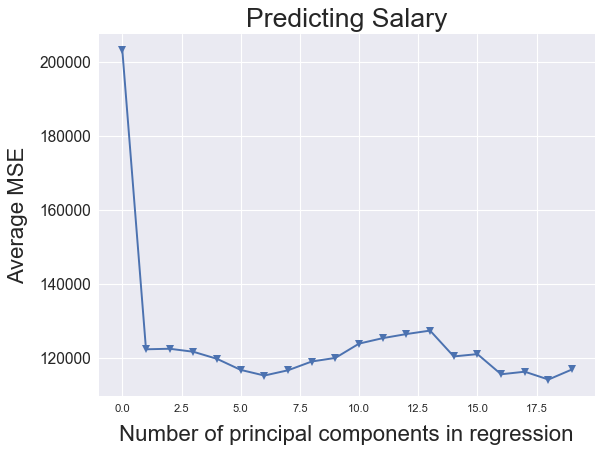

In [9]:
# Plot average MSEs against the number of principal components
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression', fontsize=20, labelpad=10)
plt.ylabel('Average MSE', fontsize=20, labelpad=10)
plt.title('Predicting Salary', fontsize=24)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin=-1)
plt.show()

# Interpretation: smallest cross-validation error occurs when M=18 components are used. 
# (Using all 19 PCs is basically the same as performing least squares.)
# Cross-validation error is roughly the same when only one component is included in the model. 
# This suggests that a model that uses just a small number of components might suffice.

In [10]:
# Find cumulative amount of variance expained
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 38.31,  60.15,  70.84,  79.03,  84.29,  88.63,  92.26,  94.96,
        96.28,  97.25,  97.97,  98.64,  99.14,  99.46,  99.73,  99.88,
        99.95,  99.98,  99.99])

In [11]:
# Apply to training data

# Split into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Perform PCA on training data to evaluate test set performance
pca_train = PCA()

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


Accuracy: 0.26 (+/- 0.69)
Accuracy: 0.26 (+/- 0.73)
Accuracy: 0.25 (+/- 0.75)
Accuracy: 0.26 (+/- 0.72)
Accuracy: 0.25 (+/- 0.77)
Accuracy: 0.28 (+/- 0.80)
Accuracy: 0.27 (+/- 0.79)
Accuracy: 0.25 (+/- 0.77)
Accuracy: 0.20 (+/- 0.80)
Accuracy: 0.14 (+/- 0.94)
Accuracy: 0.13 (+/- 0.98)
Accuracy: 0.12 (+/- 1.00)
Accuracy: 0.10 (+/- 1.01)
Accuracy: 0.09 (+/- 1.00)
Accuracy: 0.10 (+/- 1.01)
Accuracy: 0.12 (+/- 1.14)
Accuracy: 0.11 (+/- 1.20)
Accuracy: 0.14 (+/- 1.09)
Accuracy: 0.13 (+/- 1.12)


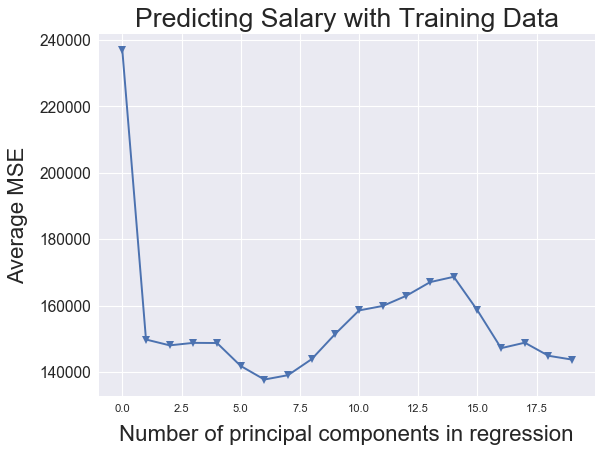

In [12]:
# Verify number of PCs with smallest MSE on X_train
Z_train = pca_train.fit_transform(scale(X_train))
n = len(Z_train)

# Prepare 10-fold CV, with shuffle
kf_10 = KFold(10, shuffle=True, random_state=1)
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate average MSEs using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, Z_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    score2 = cross_val_score(regr, Z_train[:,:i], y_train.ravel(), cv=kf_10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))
    mse.append(score)
    
# Plot average MSEs against the number of principal components
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression', fontsize=20, labelpad=10)
plt.ylabel('Average MSE', fontsize=20, labelpad=10)
plt.title('Predicting Salary with Training Data', fontsize=24)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin=-1)
plt.show()

# Interpretation: lowest cross-validation error occurs when M=6 components used

In [13]:
# Apply to test data

# Dimensionally reduce training data using 1st 6 PCs
Z_train_reduced = Z_train[:, :6]
# Dimensionally reduce test data using 1st 6 PCs obtained from PCA of training data
Z_test_reduced = pca_train.transform(scale(X_test))[:,:6]

# Train regression model on training data
regr = LinearRegression()
regr.fit(Z_train_reduced, y_train)

# Use model to predict values from test data
pred = regr.predict(Z_test_reduced)
print("Predictions:", np.asarray(pred).round(0))
print("Actual:", np.asarray(y_test))
mean_squared_error(y_test, pred)

Predictions: [  528.   240.   630.   561.   411.   936.   339.   -33.   792.   379.
   259.  1291.   379.   776.   866.   156.   985.   549.   177.   517.
   165.   203.   486.   222.   618.   512.   987.   826.   999.   358.
   707.   410.   518.   383.   581.   398.   981.   717.   178.   555.
   390.   423.   693.   892.   467.   737.   100.   167.   651.   206.
   232.   314.   605.   998.   365.   621.   931.   205.   352.   474.
  1047.   167.   486.   302.   673.   671.   544.   612.   311.   222.
   245.   100.   196.   458.    31.   360.   837.   287.   320.   675.
  1400.    99.   390.   342.   412.   580.   102.   326.   737.   860.
   860.   -61.   638.   959.   322.   292.   746.   301.   520.   209.
  1243.   744.   561.  1038.   769.   906.  1169.   278.   597.   505.
    39.   183.   433.    64.   892.   609.    45.   141.   384.   575.
   168.   625.   704.   859.  1059.  1617.   935.   690.   454.   682.
   847.   565.]
Actual: [  500.      700.      700.      210.   

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


112167.15685435769

In [14]:
# Finding SPE (method 1)
# SPE = xV_0V_0'x'
# V_0 is the null space of the zero singular values (contains the 8 eliminated PCs)
# x refers to test data ()

x = scale(X_test)
V_0 = pca_train.components_[6:, :].T
print(V_0.shape)
print(x.shape)
SPE2 = np.matmul(V_0.T, x.T) 
SPE1 = np.matmul(V_0, SPE2)
SPE = np.matmul(x, SPE1)
print(SPE.shape)
#print(SPE)

# Diagonals correspond to SPEs for each test sample
print(SPE.diagonal())

(19, 13)
(132, 19)
(132, 132)
[ 2.01082415  0.89147962  5.3979998   4.50955845  1.91881641  2.79457361
  0.7681947   0.63735315  4.95167608  4.37763821  1.98686736  2.29737978
  1.05258229  2.25618068  5.03485996  0.7973987   0.95881767  2.50583878
  5.69739718  8.52051403  2.12970513  1.21088541  2.55229018  3.35385773
  1.08604125  3.6265836   2.1909771   1.81437243  2.45716292  0.17538504
  7.42107388  3.79088013  1.15310586  1.20669008  2.14893486  1.04547924
  6.747568    5.34817743  2.34855858  4.38021875  0.91467696  1.86659636
  5.68735841  3.28192362  0.84732336  2.07688467  0.86542978  0.78298033
  5.15134179  0.85204902  0.87808134  4.04977836  2.05940448  9.28435692
  3.91345592  1.58313463  2.26795542  1.03363739  0.34163447  0.96454933
  6.08914004  0.40231307  0.84242227  0.3104583   4.35382448  1.74501066
  1.74446123  2.06382252  1.26998614  1.34603223  1.25988993  1.05179526
  1.2091702   3.5497376   0.83871774  3.56201436  0.36386772  5.35022521
  2.55896058  1.53194

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
